## Importy types

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import math 
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Training & Test set

First load the data set and the dependend and independend variables

In [128]:
csv_file = './data/palmerpenguins_original.csv'
data = pd.read_csv(csv_file)

df = data.loc[:, ['species', 'sex', 'bill_length_mm', 'body_mass_g']]
df = df.dropna()
df

,species,sex,bill_length_mm,body_mass_g
0,Adelie,male,39.1,3750.0
1,Adelie,female,39.5,3800.0
2,Adelie,female,40.3,3250.0
4,Adelie,female,36.7,3450.0
5,Adelie,male,39.3,3650.0
...,...,...,...,...
339,Chinstrap,male,55.8,4000.0
340,Chinstrap,female,43.5,3400.0
341,Chinstrap,male,49.6,3775.0
342,Chinstrap,male,50.8,4100.0


Regular strings are not processable by the neural network. So instead i give every species a category and instead of sex i create the boolean is_male.

And normalize the values so the correct values get predicted.

In [129]:
def get_specimen_index(sp: str) -> int:
    species = df['species'].unique()
    for i in range(len(species)):
        if species[i].lower() == sp.lower():
            return i
    return 0

dataset = df
dataset['species_category'] = [get_specimen_index(sp) for sp in df['species']]
dataset['is_male'] = [1 if sex == 'male' else 0 for sex in df['sex']]
dataset = dataset.drop(columns=['species', 'sex'])

dataset


,bill_length_mm,body_mass_g,species_category,is_male
0,39.1,3750.0,0,1
1,39.5,3800.0,0,0
2,40.3,3250.0,0,0
4,36.7,3450.0,0,0
5,39.3,3650.0,0,1
...,...,...,...,...
339,55.8,4000.0,2,1
340,43.5,3400.0,2,0
341,49.6,3775.0,2,1
342,50.8,4100.0,2,1


In [130]:
X = dataset.loc[:, ['bill_length_mm', 'is_male', 'species_category']]
Y = dataset['body_mass_g']

In [131]:
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

For the training process i split the dataset in a training and test set so i than later can benchmark the perceptron.

Test set 20%
Train set & Validation set 80%

In [132]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

#### Write an activation function. Choose between Sigmoid, ReLu or Swish. Explain in the final report why this one.

For the Perceptron I chose the ReLU activation function because:

-   Lower computational cost
-	Simple derivative (1 when input > 0, 0 otherwise)
-	Prevents negative outputs (Negative penguin weights)

I also read that sigmoid is mostly used for classification, and the Swish activation function will only really make a difference in a more complex network.


In [133]:
def relu_activation_function(x):
    return max(0, x) 

def relu_activation_function_derivative(x):
    return 1 if x > 0 else 0

#### Write a loss function. Choose either Square Loss, Absolute Loss or Huber Loss. Explain in the final report why you chose this one.

For the perceptron I chose the Squared loss function because:
-	Squared loss penalizes larger errors more than small ones, accelerating the training process
-	It is simple to differentiate
-	This makes the function faster, more efficient, and simpler to implement and understand


In [134]:
def squared_loss(target: float, predicted: float):
    return (target - predicted) ** 2

def squared_loss_derivative(target: float, predicted: float):
    return -2 * (target - predicted)

#### Create a function which sets the initial weights of the network. This means the input of the function is the network itself, the output the same network but now with the weights being set to an initial value. Initialize all weights with a random value

In [135]:
class Perceptron:

    def fit(self, X, Y, learning_rate=0.0001, epochs=100, x_val=None, y_val=None):
        """
        Train the perceptron model on the given data.
        """
    
        losses = {
            "train": {"mse": []},
            "validation": {"mse": []}
        }
        
        for epoch in range(epochs):
            train_metrics = self._train_epoch(X, Y, learning_rate)

            losses["train"]["mse"].append(train_metrics["mse"])
            
            # Run validation if data is provided
            val_msg = ""
            if x_val is not None and y_val is not None:
                val_metrics = self._validate(x_val, y_val)
                
                # Store validation metrics
                losses["validation"]["mse"].append(val_metrics["mse"])
                
                val_msg = f", Val MSE = {float(val_metrics['mse']):.2f}"
            else:
                losses["validation"]["mse"].append(None)
    
            print(f"Epoch {epoch}: Train MSE = {float(train_metrics['mse']):.2f}{val_msg}")

        return losses
    
    def _train_epoch(self, X, Y, learning_rate):
        """Train for a single epoch and return metrics."""
        predictions = []
        total_loss = 0

        for i, row in X.iterrows():
            x1, x2, x3 = row
            y = Y[i]

            ypred = self.predict(x1, x2, x3)
            predictions.append(ypred)

            loss = squared_loss(y, ypred)
            total_loss += loss

            self._update_weights(x1, x2, x3, y, ypred, learning_rate)

        mse = total_loss / len(X)
        
        return {
            "mse": mse,
            "predictions": predictions
        }
    
    def _update_weights(self, x1, x2, x3, target, prediction, learning_rate):
        """Update the model weights based on prediction error."""
        # Calculate the weighted sum (input to ReLU)
        weighted_sum = x1 * self.w1 + x2 * self.w2 + x3 * self.w3 + self.bias
        
        # Derivative of ReLU: 1 if weighted_sum > 0, else 0
        # Gradient of squared error: -2 * (target - prediction)
        
        # Combined gradient (chain rule)
        # Gradient = f'error(f act(sum)) * f'act(sum)
        gradient = squared_loss_derivative(target, prediction) * relu_activation_function_derivative(weighted_sum)

        self.w1 -= learning_rate * gradient * x1
        self.w2 -= learning_rate * gradient * x2
        self.w3 -= learning_rate * gradient * x3
        self.bias -= learning_rate * gradient
    
    def _validate(self, X, Y):
        """Validate the model and return metrics."""
        predictions = []
        total_loss = 0

        for i, row in X.iterrows():
            x1, x2, x3 = row
            y = Y[i]

            ypred = self.predict(x1, x2, x3)
            predictions.append(ypred)

            total_loss += squared_loss(y, ypred)

        mse = total_loss / len(X)
        
        return {
            "mse": mse,
            "predictions": predictions
        }
    
    def predict(self, x1, x2, x3):
        """Predict the output for given inputs."""
        weighted_sum = x1 * self.w1 + x2 * self.w2 + x3 * self.w3 + self.bias
        return relu_activation_function(weighted_sum)
    
    def evaluate(self, X, Y):
        """Evaluate model on test data and return metrics."""
        return self._validate(X, Y)

In [136]:
def initialize_network(nn: Perceptron) -> Perceptron:    
    nn.w1 = rd.random()
    nn.w2 = rd.random()
    nn.w3 = rd.random()
    nn.bias = rd.random()

    return nn

# Initialize network

## Train perceptron

I searched up an what an ideal learning rate would be and i found out on multiple websites that the learning rate is mostly 0.001 to 0.1.
For the epochs i just picked an random number.

In [137]:
perceptron = Perceptron()
initialize_network(perceptron)

losses = perceptron.fit(
    x_train,
    y_train,
    epochs=100, 
    learning_rate=0.0001,
    x_val=x_val,
    y_val=y_val
)

Epoch 0: Train MSE = 597669.13, Val MSE = 799329.17
Epoch 1: Train MSE = 509400.67, Val MSE = 789870.85
Epoch 2: Train MSE = 505883.08, Val MSE = 780726.80
Epoch 3: Train MSE = 502518.85, Val MSE = 771885.36
Epoch 4: Train MSE = 499301.23, Val MSE = 763335.32
Epoch 5: Train MSE = 496223.77, Val MSE = 755065.92
Epoch 6: Train MSE = 493280.33, Val MSE = 747066.84
Epoch 7: Train MSE = 490465.00, Val MSE = 739328.18
Epoch 8: Train MSE = 487772.17, Val MSE = 731840.42
Epoch 9: Train MSE = 485196.44, Val MSE = 724594.42
Epoch 10: Train MSE = 482732.69, Val MSE = 717581.42
Epoch 11: Train MSE = 480375.98, Val MSE = 710792.99
Epoch 12: Train MSE = 478121.63, Val MSE = 704221.04
Epoch 13: Train MSE = 475965.14, Val MSE = 697857.81
Epoch 14: Train MSE = 473902.20, Val MSE = 691695.82
Epoch 15: Train MSE = 471928.73, Val MSE = 685727.91
Epoch 16: Train MSE = 470040.78, Val MSE = 679947.18
Epoch 17: Train MSE = 468234.62, Val MSE = 674347.02
Epoch 18: Train MSE = 466506.65, Val MSE = 668921.06
Epo

In [138]:
def draw_training_graph(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, 'o-', color='green', label='Training Loss')
    plt.plot(val_loss, 'o-', color='lightblue', label='Validation Loss')
    plt.title('Model Mean Squared Error')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


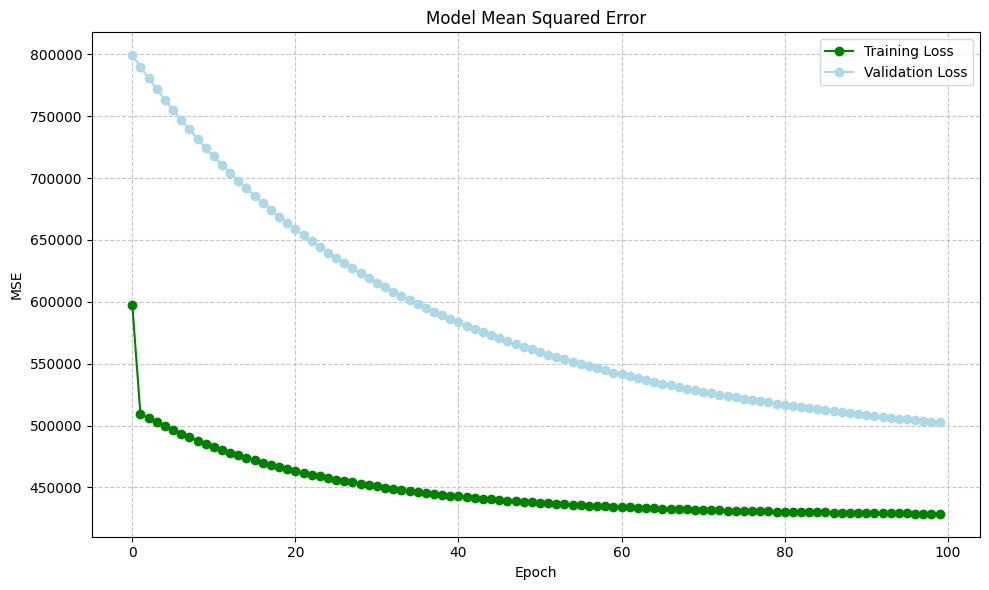

In [139]:

draw_training_graph(losses['train']['mse'], losses['validation']['mse'])

The graph of the neural network can change by rerunning it a few times you can get a correct one. Where the validation loss is lower highter than the training loss.

In [140]:
mse = 0

for i, row in x_test.iterrows():
    x1, x2, x3 = row
    y = y_test[i]

    prediction = perceptron.predict(x1, x2, x3)
    
    # Calculate squared error for this sample
    squared_error = (y - prediction) ** 2
    
    # Add to running sum
    mse += squared_error

# Calculate mean (average) of squared errors
mse = mse / len(x_test)

# Calculate RMSE (square root of MSE)
rmse = math.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 338742.69231556274
Root Mean Squared Error: 582.0160584688044


We can see our model right now is about half a kilo of per prediction. Something we could do is change the learning rate. I played a bit with the epochs and with the learning rate and this is about the lowest i would get. By just playing around.

By looking at these results you can conclude this simple perceptron is not good enough to predict the weight on the penguins. This may be caused by that its to simple yet.